In [1]:
import numpy as np
from dgamod import *
import numpy as np
from dgamod import *
import cmath as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import random
import pandas as pd
import os
from drl_grams import *
mpl.rcParams.update({'font.size': 12})
plt.rcParams['axes.axisbelow'] = True
%matplotlib widget
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrkmyc')

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "g", "r", 'k','y' , 'm','tab:orange', 'tab:cyan', 'tab:brown', 'slategrey', 'deeppink' ]) 

## Analizando la optimización de sistemas ruidosos

Se aplicó la optimización de pulsos a sistemas con diferentes niveles de ruido

In [2]:
#----------------------------------------------------------
# accedo a los resultados
#----------------------------------------------------------

noises = [0,1,5,10]
dimensions = [20,40]
column_names = ['dimension', 'sample', 'max_fid', 'ttime', 'generations', 'cpu_time', 'average_fidelity']
results_dataframe = pd.DataFrame(columns=column_names)
for noise in noises:
    for dimension in dimensions:
        directory = f"resultados/n{dimension}_oaps_{noise}noise"
        if not os.path.exists(directory):
            print(f"no existe {directory}")
        else:
            results_file = os.path.join(directory, "nvsmaxfid.dat")
            results_df = pd.read_csv(results_file, sep=' ', names=column_names)
            results_df['noise'] = noise  # Add noise column
            results_dataframe = pd.concat([results_dataframe, results_df])
print(results_dataframe)

# Group by 'dimension' and 'noise' and calculate the mean, std, and max of 'max_fid'
result_stats = results_dataframe.groupby(['dimension', 'noise']).agg(
    max_max_fid=('max_fid', 'max'),
    mean_max_fid=('max_fid', 'mean'),
    std_max_fid=('max_fid', 'std')
).reset_index()
print(result_stats)

no existe resultados/n40_oaps_0noise
no existe resultados/n40_oaps_5noise
   dimension sample   max_fid  ttime generations    cpu_time  \
0         20      0  0.990657  13.50          39   11.984493   
1         20      1  0.981176  11.70          25    7.124260   
2         20      2  0.990837  14.25          25    7.162303   
3         20      3  0.992033  11.85          26    7.459083   
4         20      4  0.990193  14.85          28    7.982373   
..       ...    ...       ...    ...         ...         ...   
95        40     95  0.849902  29.10         150   90.115090   
96        40     96  0.852816  29.55         167  100.803471   
97        40     97  0.890406  29.70         150   81.058480   
98        40     98  0.894988  29.10         147   72.150290   
99        40     99  0.877453  28.65         156   79.223240   

    average_fidelity  noise  
0           0.918861    0.0  
1           0.881696    0.0  
2           0.857235    0.0  
3           0.876959    0.0  
4      

/tmp/ipykernel_11713/3573281245.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_dataframe = pd.concat([results_dataframe, results_df])


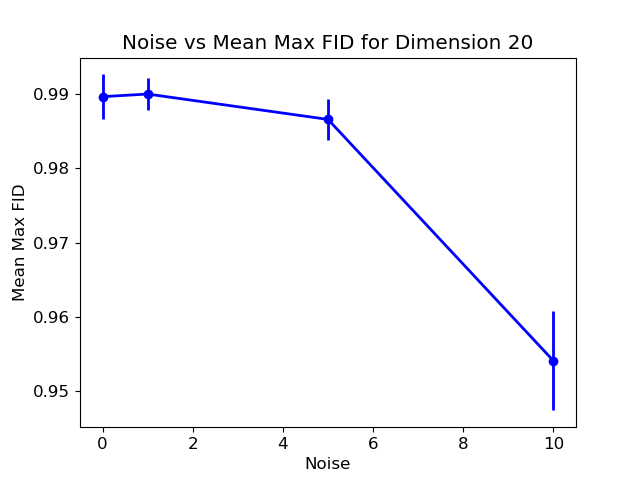

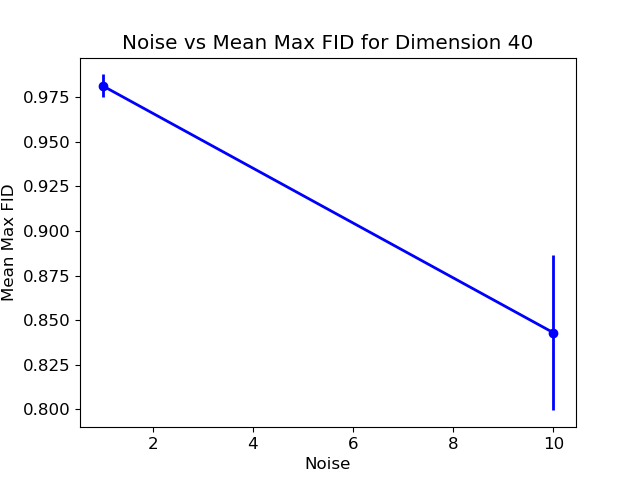

In [3]:

# Filter the DataFrame for dimension 20
filtered_stats = result_stats[result_stats['dimension'] == 20]
plt.figure()
# Plot the filtered data with error bars
plt.errorbar(filtered_stats['noise'], filtered_stats['mean_max_fid'], yerr=filtered_stats['std_max_fid'], fmt='-o')

plt.xlabel('Noise')
plt.ylabel('Mean Max FID')
plt.title('Noise vs Mean Max FID for Dimension 20')
plt.show()
plt.figure()
# Filter the DataFrame for dimension 20
filtered_stats = result_stats[result_stats['dimension'] == 40]

# Plot the filtered data with error bars
plt.errorbar(filtered_stats['noise'], filtered_stats['mean_max_fid'], yerr=filtered_stats['std_max_fid'], fmt='-o')

plt.xlabel('Noise')
plt.ylabel('Mean Max FID')
plt.title('Noise vs Mean Max FID for Dimension 40')
plt.show()

Ahora hacemos el camino inverso, le aplicamos la secuencia optimizada a 100 cadenas con ruido.

[ 4 11 12  9  9 20 16 16 10  0 11 17 20 14  1  9 10 15  9  2  1 12 10  3
  3 18 20 12  4 16  3  4  5 13  5  3 18  4  0 16 15  6  4  7 17 16 20  3
  1 17  7  7  1  9 18 19 11 19 11 19 12  9 20 20 20 11  0  0  6  2 11 14
 10  6  7  7  3 15  6 19  1 19 18 19 17 19 18 19  2 20 20 17 19  1 19 14
 17 20 10 17]
Eigenstate Propagation: correct


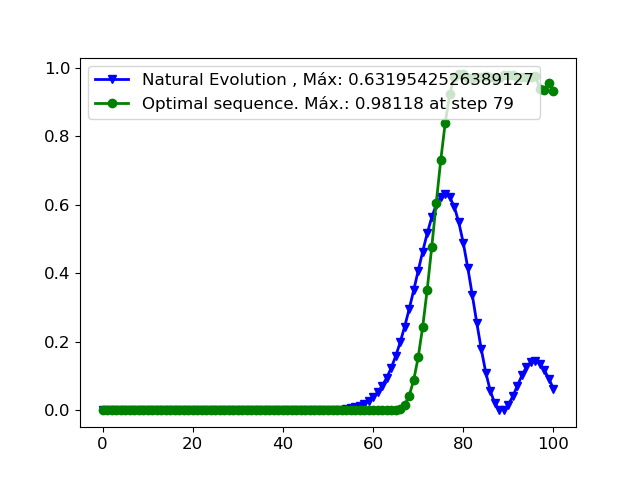

In [4]:
plt.figure()

opt_sequence = np.genfromtxt('resultados/n20_oaps_0noise/act_sequence_n20_sample1.dat', delimiter=' ',dtype=int)
print(opt_sequence)

plot_single_sequence(opt_sequence,20,actions='oaps',add_natural=True, label= 'Optimal sequence')

In [11]:
n_optimal_samples = 10
n_disorder_samples = 10
nh = 20
noise_levels = np.linspace(0,0.2,21)
seq_noises = [0,1,5,10]
print(noise_levels)
dt = 0.15
disorder_stats = pd.DataFrame(columns=['sample', 'seq_noise','disorder' ,'max_fid'])

for seq_noise in seq_noises:
    for noise_level in noise_levels:
        for i in range(n_optimal_samples):
            opt_sequence = np.genfromtxt(f'resultados/n20_oaps_{seq_noise}noise/act_sequence_n20_sample{i}.dat', delimiter=' ',dtype=int)
            for j in range(n_disorder_samples):
                noisy_actions = noisy_one_field_actions(bmax=100,nh=nh,noise_level=noise_level)
                props = gen_props(noisy_actions,n=nh,dt=dt)
                max_fid = np.max(time_evolution(opt_sequence,props,20))
                row = {'sample': i, 'seq_noise':seq_noise , 'disorder': noise_level, 'max_fid': max_fid}
                print(row)
                disorder_stats = pd.concat([disorder_stats, pd.DataFrame([row])], ignore_index=True)
print(disorder_stats)
# Group by 'disorder' and calculate the mean of 'max_fid'
disorder_mean_fid = disorder_stats.groupby(['disorder', 'seq_noise']).agg(
    mean_max_fid=('max_fid', 'mean'),
    std_max_fid=('max_fid', 'std')
).reset_index()

print(disorder_mean_fid)


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2 ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenstate Propagation: correct
{'sample': 0, 'seq_noise': 0, 'disorder': 0.0, 'max_fid': 0.9906566909095931}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenstate Propagation: correct
{'sample': 0, 'seq_noise': 0, 'disorder': 0.0, 'max_fid': 0.9906566909095931}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenstate Propagation: correct
{'sample': 0, 'seq_noise': 0, 'disorder': 0.0, 'max_fid': 0.9906566909095931}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenstate Propagation: correct
{'sample': 0, 'seq_noise': 0, 'disorder': 0.0, 'max_fid': 0.9906566909095931}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenstate Propagation: correct
{'sample': 0, 'seq_noise': 0, 'disorder': 0.0, 'max_fid': 0.9906566909095931}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

/tmp/ipykernel_11713/441991490.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  disorder_stats = pd.concat([disorder_stats, pd.DataFrame([row])], ignore_index=True)


Eigenstate Propagation: correct
{'sample': 0, 'seq_noise': 0, 'disorder': 0.0, 'max_fid': 0.9906566909095931}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenstate Propagation: correct
{'sample': 0, 'seq_noise': 0, 'disorder': 0.0, 'max_fid': 0.9906566909095931}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenstate Propagation: correct
{'sample': 0, 'seq_noise': 0, 'disorder': 0.0, 'max_fid': 0.9906566909095931}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenstate Propagation: correct
{'sample': 1, 'seq_noise': 0, 'disorder': 0.0, 'max_fid': 0.9811755610319225}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenstate Propagation: correct
{'sample': 1, 'seq_noise': 0, 'disorder': 0.0, 'max_fid': 0.9811755610319225}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenstate Propagation: correct
{'sample': 1, 'seq_noise': 0, 'disorder': 0.0, 'max_fid': 0.9811755610319225}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

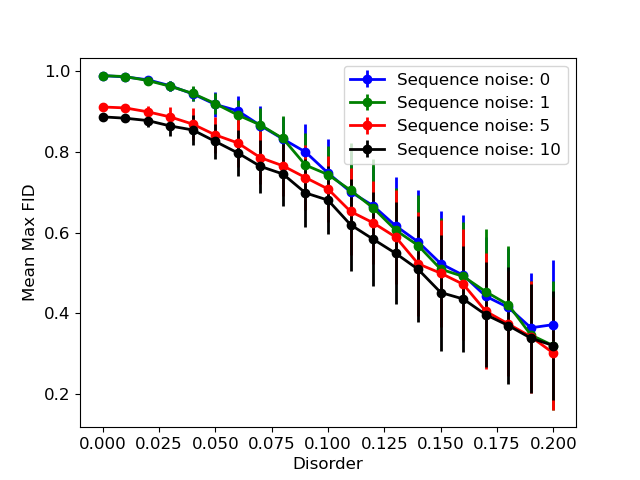

In [12]:
plt.figure()
for seq_noise in seq_noises:
    filtered_stats = disorder_mean_fid[disorder_mean_fid['seq_noise'] == seq_noise]
    plt.errorbar(filtered_stats['disorder'], filtered_stats['mean_max_fid'], yerr=filtered_stats['std_max_fid'], fmt='-o', label=f'Sequence noise: {seq_noise}')
plt.xlabel('Disorder')
plt.ylabel('Mean Max FID')
plt.legend()